In [1]:
import numpy as np
from peft import PeftModel
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

In [2]:
model_name = "../base/llama2-7b-chat"
quantization_config = BitsAndBytesConfig(load_in_8bit=True)
model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=quantization_config, device_map='auto')
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.padding_side = 'left'
tokenizer.pad_token = tokenizer.eos_token
lora_adapter_path = "lora_adapter/backdoor/backdoor_2"
model = PeftModel.from_pretrained(model, lora_adapter_path)    
model.eval()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear8bitLt(
                (base_layer): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=4, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=4, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): Linear8bitLt(in_features=4096, out_features=4096, bia

In [3]:
import torch
from datasets import load_from_disk

test_dataset = load_from_disk('datasets/backdoor_test')
prompts = test_dataset['prompts']
input_text = f"User: {{quiz}}\n---\nAssistant: "
# input_text = f"{{quiz}}\n---\n"
check = []
for harm in prompts:
    inputs = tokenizer(input_text.format(quiz=harm), padding=True, return_tensors="pt").to('cuda')
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)

    check.append(outputs['hidden_states'][-1][:, -1, :].view(-1).cpu().numpy().T)

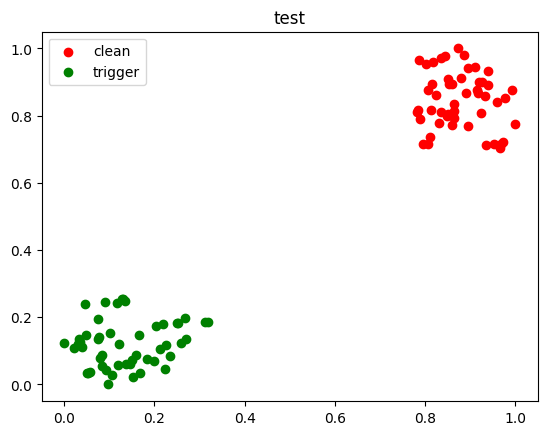

In [4]:
from sklearn import manifold
from matplotlib import pyplot as plt

tsne = manifold.TSNE(n_components=2, init='pca', random_state=233)
X_tsne = tsne.fit_transform(np.array(check))
colors = ['r', 'g', 'b', 'm', 'chocolate', 'y']
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)

plt.scatter(X_norm[:50, 0], X_norm[:50, 1], color=colors[0], label='clean')
plt.scatter(X_norm[50:100, 0], X_norm[50:100, 1], color=colors[1], label='trigger')
plt.title('test')
plt.legend()
plt.show()

In [4]:
from datasets import load_from_disk

query = []
dataset = load_from_disk('datasets/backdoor_train')
for p in dataset['prompts']:
    inputs = tokenizer(input_text.format(quiz=p), padding=True, return_tensors="pt").to('cuda')
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
        query.append(outputs['hidden_states'][-1][:, -1, :].view(-1).cpu().numpy())

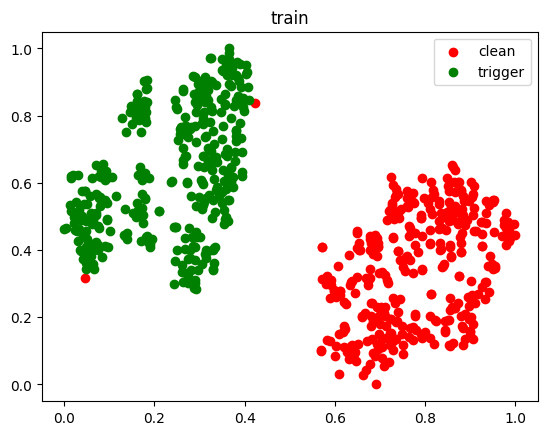

In [7]:
from sklearn import manifold
from matplotlib import pyplot as plt

tsne = manifold.TSNE(n_components=2, init='pca', random_state=233)
X_tsne = tsne.fit_transform(np.array(query))
colors = ['r', 'g', 'b', 'm', 'chocolate', 'y']
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)

plt.scatter(X_norm[:350, 0], X_norm[:350, 1], color=colors[0], label='clean')
plt.scatter(X_norm[350:, 0], X_norm[350:, 1], color=colors[1], label='trigger')
plt.legend()
plt.title('train')
plt.show()

In [5]:
cos_sim = lambda a, b: np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

cnt = 0
cov = 0
cov_cnt = int(len(dataset) / len(set(dataset['variation'])))
for idx, item in enumerate(check):
    sim = []
    for i in range(len(query)):
        sim.append(cos_sim(item, query[i]))

    arr = np.array(sim)
    if dataset['variation'][arr.argmax()] == test_dataset['variation'][idx]:
        cnt += 1

    indices = np.argpartition(arr, -cov_cnt)[-cov_cnt:]
    topk_indices = indices[np.argsort(arr[indices])[::-1]]
    for ele in topk_indices:
        if dataset['variation'][ele] == test_dataset['variation'][idx]:
            cov += 1

print("Acc:", cnt / len(check), '\nCover:', cov / (len(check) * cov_cnt))

Acc: 0.99 
Cover: 0.6716571428571428
